# Cross-Correaltion Analysis

## Import pkg, Set the Run-Directory and set File-format for Saving Plots:

In [1]:
import argparse
import h5py 
import numpy as np
from numpy.fft import fftn, fftshift, fft ## no need to use numpy.fft.fftn/fftshift##
import matplotlib.cm as cm
import matplotlib.pyplot as pypl
from matplotlib import ticker
from matplotlib.patches import Circle
# pypl.rcParams["image.cmap"] = "jet" ## Change default cmap from 'viridis to 'jet ##
from loki.RingData import RadialProfile,DiffCorr, InterpSimple ## scripts located in RingData-folder ##
#from pylab import *	# load all Pylab & Numpy
# %pylab	# code as in Matlab
import os, time
import gc
#this_dir = os.path.dirname(os.path.realpath(__file__)) ## Get path of directory
this_dir = os.path.dirname(os.path.realpath('CrossCA_84-run_qvsq.py')) ##for testing in ipython
if "/home/" in this_dir: #/home/cldah/cldah-scratch/ or /home or 
	os.environ['QT_QPA_PLATFORM']='offscreen'
cart_diff, pol_all, pair_diff, all_DC_diff, pair_all = False,False,False, False, False ## only one should be true !!

## Function for Loading data from Condor CXI-Files


In [ ]:
def load_cxi_data(data_file, get_parameters=False, Amplitudes = False):
	"""
	Reads simulation data from 'data_file'
	 If Amplitudes is true, then the absolut value of the amplitudes (complex) is returned instead.

		In:
	data_file           the cxi-file/s from Condor to be read in.
	get_parameters      Determines if the static simulation parameters should be retured, Default = False.
	##ip, ap              The intensity pattern, amplitude patterns and patterson image respectively as list, the 
						     loaded vaules from 'data_file' are appended to these lists.
	=====================================================================================
		Out:
	intensity/amplitude_patterns   the loaded intensity/amplitude patterns from the cxi.file.
	#ip, ap              list-objects with the data loaded from 'data_file' appended.
	photon_e_eV         Photon Energy of source in electronVolt [eV], type = int, (if get_parameters = True)
	wl_A                Wavelength in Angstrom [A], type = float, (if get_parameters = True)
	ps                  Pixel Size [um], type = int, (if get_parameters = True)
	dtc_dist            Detector Distance [m], type = float, (if get_parameters = True)

	"""
	with h5py.File(data_file, 'r') as f:
		if get_parameters:
			photon_e_eV = np.asarray(f["source/incident_energy"] )			# [eV]
			photon_e_eV = int(photon_e_eV[0]) 								# typecast 'Dataset' to int

			photon_wavelength = np.asarray(f["source/incident_wavelength"]) #[m]
			photon_wavelength= float(photon_wavelength[0])					# typecast 'Dataset' to float
			wl_A = photon_wavelength*1E+10 									#[A]

			psa = np.asarray(f["detector/pixel_size_um"])  					#[um]
			ps = int(psa[0]) 												# typecast 'Dataset' to int

			dtc_dist_arr = np.asarray(f["detector/detector_dist_m"])		#[m]
			dtc_dist = float(dtc_dist_arr[0]) 								# typecast 'Dataset' to float

			shots_recorded = f["entry_1/data_1/data"].shape[0]

			if Amplitudes:
				amplitudes_pattern = np.asarray(f["entry_1/data_1/data_fourier"])
			else: 
				intensity_pattern = np.asarray(f["entry_1/data_1/data"])

		else:
			if Amplitudes:
				amplitudes_pattern = np.asarray(f["entry_1/data_1/data_fourier"])
			else: 
				intensity_pattern = np.asarray(f["entry_1/data_1/data"])

	if get_parameters:
		if Amplitudes:
			return photon_e_eV, wl_A, ps, dtc_dist, shots_recorded, np.abs(amplitudes_pattern)
		else:
			return photon_e_eV, wl_A, ps, dtc_dist, shots_recorded,intensity_pattern
	else:
		if Amplitudes:
			#ap.extend(amplitudes_pattern), return ap
			return np.abs(amplitudes_pattern)
		else:
			#ip.extend(intensity_pattern),  return ip
			return intensity_pattern
# ------------------------------------------------------------

## Function for Calculating the Cross-Correlations:

In [ ]:
def calc_cc(img, cntr, q_map, mask, data_hdf, 
		beam_eV, wavelength_A, pixel_size_m, detector_distance_m):
	"""
	Caclulate the Auto-Correlation and the Cross-Correlation for the imported 'data' with LOKI.

	In:
	================
	img 			the shots loaded from the specific CXI-file. dim (N,Y,X)
	cntr 			the beam center (Y,X)
	q_map 			the Qs stored in inv Angstrom and in pixels. dim (k,3),
						with  column 0 = index, column 1 = q [inv A], column 2: q [pixels]
	mask 			Pixel Maske with dead or none pixels masked out. no pixel = 0
						pixel = 1. dim (Y,X) must be the same X,Y as in images.
	data_hdf 		the hdf5-file handler for storing the data.
	beam_eV 		the beam energy [eV] from the simulation
	wavelength_A  	the beam wavelength [A] from the simulation
	pixel_size_m 	the pixel size [m] for the detector in the simulation
	detector_distance_m 	the distance [m] between the sample and the detctor in the simulation
	"""
	
	t_CC = time.time()

	shot_count = img.shape[0]
	# ---- Single Pixel Resolution at Maximum q [1/A]: -----
	nphi = 360#180#

	# ---- Save g-Mapping (the q- values [qmin_pix,qmin_pix]): ----
	qmin_pix, qmax_pix = q_map[0,2] , q_map[-1,2] ## first and last values in cloumn 2 = q [pixels] ##

	# ---- Interpolater initiate : ----	# fs = fast-scan {x} cntr[0]; Define a polar image with dimensions: (qRmax-qRmin) x nphi
	Interp = InterpSimple( cntr[0], cntr[1], qmax_pix, qmin_pix, nphi, mask.shape)

	# ---- Make a Polar Mask (if ACC_wo_MASK=True then just an array of 1s) : ----
	#if ACC_wo_MASK:	 mask = np.ones_like(mask)
	if not bool(args.w_MASK):	 mask = np.ones_like(mask)
	polar_mask = Interp.nearest(mask, dtype=bool).round() ## .round() returns a floating point number that is a rounded version of the specified number ##
	

	# ---- Calculate the Difference in Intensities and store in a List (N-1 ACC): ----
	if cart_diff:
		#exposure_diffs_cart =img[:-1]-img[1:]				# Intensity Patterns in Carteesian cor
		img_mean = np.array([ img[i][img[i]>0.0].mean() for i in range(img.shape[0]) ]) ## Calculate the Mean of each pattern(shot) ##
		#exposure_diffs_cart= img[:-1,:,:]/img_mean[:-1]-img[1:,:,:]/img_mean[1:]  ## Normalize each pattern(shot) before subtraction ##
		exposure_diffs_cart = np.array([  img[i][:,:]/img_mean[i]-img[i+1][:,:]/img_mean[i+1]    for i in range(img.shape[0]-1) ])
		#exposure_diffs_cart = np.divide(img[:-1,:,:], img_mean[:-1], out=img.shape)#, where=corr_mask!=0) 
		del img,img_mean 	## Do not need the mean-values anymore ##
		gc.collect() ## Free up Memory: ##
		exposure_diffs_cart = np.asarray(exposure_diffs_cart) 	# = (4, 1738, 1742)
		exposure_diffs_cart = polarize(exposure_diffs_cart)  ## Polarize (if no fraction given => just 1s) ##
		#exposure_diffs_cart = norm_data(exposure_diffs_cart):
		## ---- Conv to polar of diff-data : ---- ##
		print "\n Starting to Calculate the Polar Images..."
		exposure_diffs_cart = np.array( [ polar_mask* Interp.nearest(exposure_diffs_cart[i]) for i in range(exposure_diffs_cart.shape[0]) ] ) 
		pttrn = "cart-diff"
		# if 'exposure_diffs_cart' not in data_hdf.keys(): data_hdf.create_dataset( 'exposure_diffs_cart', data = np.asarray(exposure_diffs_cart))
		# else: 
		# 	del data_hdf['exposure_diffs_cart']
		# 	dset = data_hdf.create_dataset('exposure_diffs_cart', data=np.asarray(exposure_diffs_cart))
		
		exposures = exposure_diffs_cart 
		#DC=DiffCorr( exposure_diffs_cart  )
		del  exposure_diffs_cart 
		gc.collect() ## Free up Memory: ##

		## ---- Calc from polar Images, ALL shots: ---- ##
	elif pol_all or all_DC_diff:
		# ---- Generate Polar Image/Images (N Diffracton Patterns) : ----
		print "\n Starting to Calculate the Polar Images..."
		polar_imgs = np.array( [ polar_mask* Interp.nearest(img[i]) for i in range( img.shape[0]) ] )
		## ---- Normalize - with function: ---- ##
		## alt try: polar_imgs_norm = norm_data(polar_imgs)

		exposures =  polar_imgs # polar_imgs_norm
		#DC=DiffCorr( polar_imgs  )
		del img, polar_imgs #,polar_imgs_norm
		gc.collect() ## Free up Memory: ##
		#exposure_diffs_pol = np.asarray(exposure_diffs_pol) 	# = (4, 190, 5)
		#pttrn = "polar-diff"
		pttrn = "polar-all"
		if all_DC_diff: pttrn = "all-DC-diff"

		## ---- Calc difference of images from sequential Pairs of Images and convert to polar diff-pairs-images: ---- ##
	elif pair_diff :
		#polar_imgs = np.array( [ polar_mask* Interp.nearest(img[i]) for i in range( img.shape[0]) ] )
		#exp_diff_pairs = polar_imgs[:-1:2]-polar_imgs[1::2]
		#del img, polar_imgs
		exp_diff_pairs = img[:-1:2]-img[1::2]
		del img
		gc.collect() ## Free up Memory: ##
		exp_diff_pairs = np.asarray(exp_diff_pairs)
		print "\n Starting to Calculate the Polar Images..."
		exp_diff_pairs = np.array( [ polar_mask* Interp.nearest(exp_diff_pairs[i]) for i in range(exp_diff_pairs.shape[0]) ] ) 
		pttrn = "pairs"

		exposures = exp_diff_pairs #exposure_diffs_cart #exposure_diffs_pol
		#DC=DiffCorr( exp_diff_pairs  )
		del exp_diff_pairs 
		gc.collect() ## Free up Memory: ##

		## ---- Calc difference of images from all combinations of Pairs of Images and convert to polar diff-pairs-images: ---- ##
	elif pair_all :
		#polar_imgs = np.array( [ polar_mask* Interp.nearest(img[i]) for i in range( img.shape[0]) ] )
		exp_diff_pairs = []
		for i in range(img.shape[0]):
			for j in range(img.shape[0]):
				if j != i: 
					diff_img = img[i]-img[j]
					exp_diff_pairs.extend(diff_img)
		del img
		gc.collect() ## Free up Memory: ##
		exp_diff_pairs = np.asarray(exp_diff_pairs)
		print "\n Starting to Calculate the Polar Images..."
		exp_diff_pairs = np.array( [ polar_mask* Interp.nearest(exp_diff_pairs[i]) for i in range(exp_diff_pairs.shape[0]) ] ) 
		pttrn = "pair_all"

		exposures = exp_diff_pairs #exposure_diffs_cart #exposure_diffs_pol
		#DC=DiffCorr( exp_diff_pairs  )
		del exp_diff_pairs 
		gc.collect() ## Free up Memory: ##

	print "exposures vector's shape", exposures.shape ## ( Nshots x Nq x Nphi) ##
	del Interp

	diff_count = exposures.shape[0]  ## The number off differenses used in the correlation cacluations ##

	# ---- DiffCorr instance: ----##
	if all_DC_diff: DC=DiffCorr( exposures , delta_shot=None, pre_dif=False)
	else: DC=DiffCorr( exposures  ) # pre_dif=True

	# ---- Cross.correlation of each exposure: ---- ##
	print "\n Starting to Cross-Correlate the Images... "

	ccorr_q_sum_of_shots = []
	#ccorr_q_mean_of_shots = []
	#ccorr_all = np.zeros( (exposures.shape[1],exposures.shape[0],exposures.shape[1], exposures.shape[2]) )
	for qindex in range(exposures.shape[1]): ## Nshots x (Nq x Nphi), where shots=exposures (all or differences); # = 'diff_count'  ##
		cross_corr = DC.crosscorr(qindex)  ##  Nshots x (Nq x Nphi) ##
		ccorr_sum = np.sum(cross_corr, 0)  		## sum over all the shots: (Nq x Nphi) ##
		ccorr_q_sum_of_shots.append(ccorr_sum) ## in last loop: Qx(Q,phi)
		#ccorr_mean = cross_corr.mean(0) 		## mean over all the shots ##
		#ccorr_q_mean_of_shots.extend(ccorr_mean) ## (N,Q,phi)
		#ccorr_all[qindex, :, :, :]= cross_corr
	ccorr_q_sum_of_shots = np.asarray(ccorr_q_sum_of_shots) ## ? (qindex x Nq x Nphi) ##
	#ccorr_q_mean_of_shots = np.asarray(ccorr_q_mean_of_shots) ## ? (qindex x Nq x Nphi) ##
	print "\n Dim of <crosscorr> of all qindex: ", ccorr_q_sum_of_shots.shape
	del exposures

	# ---- Save the Calculated Radial Profile to the Storage File for Later Analyse/Plot (replace old data if exists): ---- ##
	#if ACC_wo_MASK: pttrn = "wo_Mask_"+ pttrn
	if not bool(args.w_MASK): pttrn = "wo_Mask_"+ pttrn
	else: pttrn = "w_Mask_"+ pttrn


	if 'cross-correlation_sum' not in data_hdf.keys(): 
		dset_cc =data_hdf.create_dataset( 'cross-correlation_sum', data = ccorr_q_sum_of_shots)
		dset_cc.attrs["diff_type"] = np.string_(pttrn)
		dset_cc.attrs["number_of_diffs"] = diff_count
		dset_cc.attrs["number_patterns"] = shot_count
		dset_cc.attrs["detector_distance_m"]= detector_distance_m 
		dset_cc.attrs["wavelength_Angstrom"]= wavelength_A 
		dset_cc.attrs["pixel_size_m"]= pixel_size_m 
		dset_cc.attrs["beam_energy_eV"]= beam_eV

	else: 
		del data_hdf['cross-correlation_sum']
		dset_cc = data_hdf.create_dataset('cross-correlation_sum', data=ccorr_q_sum_of_shots)
		dset_cc.attrs["diff_type"] = np.string_(pttrn)
		dset_cc.attrs["number_of_diffs"] = diff_count
		dset_cc.attrs["number_patterns"] = shot_count
		dset_cc.attrs["detector_distance_m"]= detector_distance_m 
		dset_cc.attrs["wavelength_Angstrom"]= wavelength_A 
		dset_cc.attrs["pixel_size_m"]= pixel_size_m 
		dset_cc.attrs["beam_energy_eV"]= beam_eV

	if 'polar_mask' not in data_hdf.keys():	data_hdf.create_dataset( 'polar_mask', data = polar_mask.astype(int)) 
	else: 
		del data_hdf['polar_mask']
		dset = data_hdf.create_dataset('polar_mask', data = polar_mask.astype(int))
	
	if 'num_phi' not in data_hdf.keys():	data_hdf.create_dataset( 'num_phi', data = nphi, dtype='i4') #INT, dtype='i1', 'i8'f16', i4=32 bit
	else: 
		del data_hdf['num_phi']
		dset = data_hdf.create_dataset('num_phi',  data = nphi, dtype='i4')
	
	if 'q_mapping' not in data_hdf.keys():	data_hdf.create_dataset( 'q_mapping', data = q_map)
	else: 
		del data_hdf['q_mapping']
		dset = data_hdf.create_dataset('q_mapping',data = q_map)
	
	if 'beam_center' not in data_hdf.keys():	data_hdf.create_dataset( 'beam_center', data = cntr)
	else: 
		del data_hdf['beam_center']
		dset = data_hdf.create_dataset('beam_center',data = cntr)

	# ---- Save by closing file: ----
	data_hdf.close()
	print "\n File Closed! \n"

	t = time.time()-t_CC
	t_m =int(t)/60
	t_s=t-t_m*60
	print "Correlation Time: ", t_m, "min, ", t_s, " s "
	print " --------------------------------------------------------------------- "
	exit(0)

Retrieve the simulated diffraction patterns and ...

In [ ]:
## ----- Fetch Simulation Parameters: ---- ##
photon_e_eV, wl_A, ps, dtc_dist, N, shots= load_cxi_data(data_file= fname, get_parameters= True, Amplitudes=Ampl_image)

# ---- Save g-Mapping (the q- values [qmin_pix to qmin_pix]): ----
pix2invang = lambda qpix : np.sin(np.arctan(qpix*(ps*1E-6)/dtc_dist )*0.5)*4*np.pi/wl_A
# invang2pix = lambda qia : np.tan(2*np.arcsin(qia*wl_A/4/pi))*dtc_dist/(ps*1E-6)
qrange_pix = np.arange( args.q_range[0], args.q_range[1]+1)
## ---- Q-Mapping with  0: indices, 1: r [inv Angstrom], 2: q[pixels] ---- ##
q_mapping = np.array( [ [ind, pix2invang(q), q] for ind,q in enumerate( qrange_pix)]) 

Add the mask to the exposures and calculate the Cross-Correlation in the function **calc_cc()**

In [ ]:
shots *= mask_better ## Add the MASK ##
calc_cc(img=shots, cntr=cntr, q_map= q_mapping, mask = mask_better, data_hdf=out_hdf, 
			beam_eV=photon_e_eV, wavelength_A=wl_A, pixel_size_m=ps*1E-6, detector_distance_m=dtc_dist)

![Fnoise_4M0-4M42_CC_q1-q2_FFT-angle-phi-0_%28qx-800_qi-300_nphi-360%29_w_Mask_polar-all_10(vmax-max1-end).png](attachment:Fnoise_4M0-4M42_CC_q1-q2_FFT-angle-phi-0_%28qx-800_qi-300_nphi-360%29_w_Mask_polar-all_10(vmax-max1-end).png)
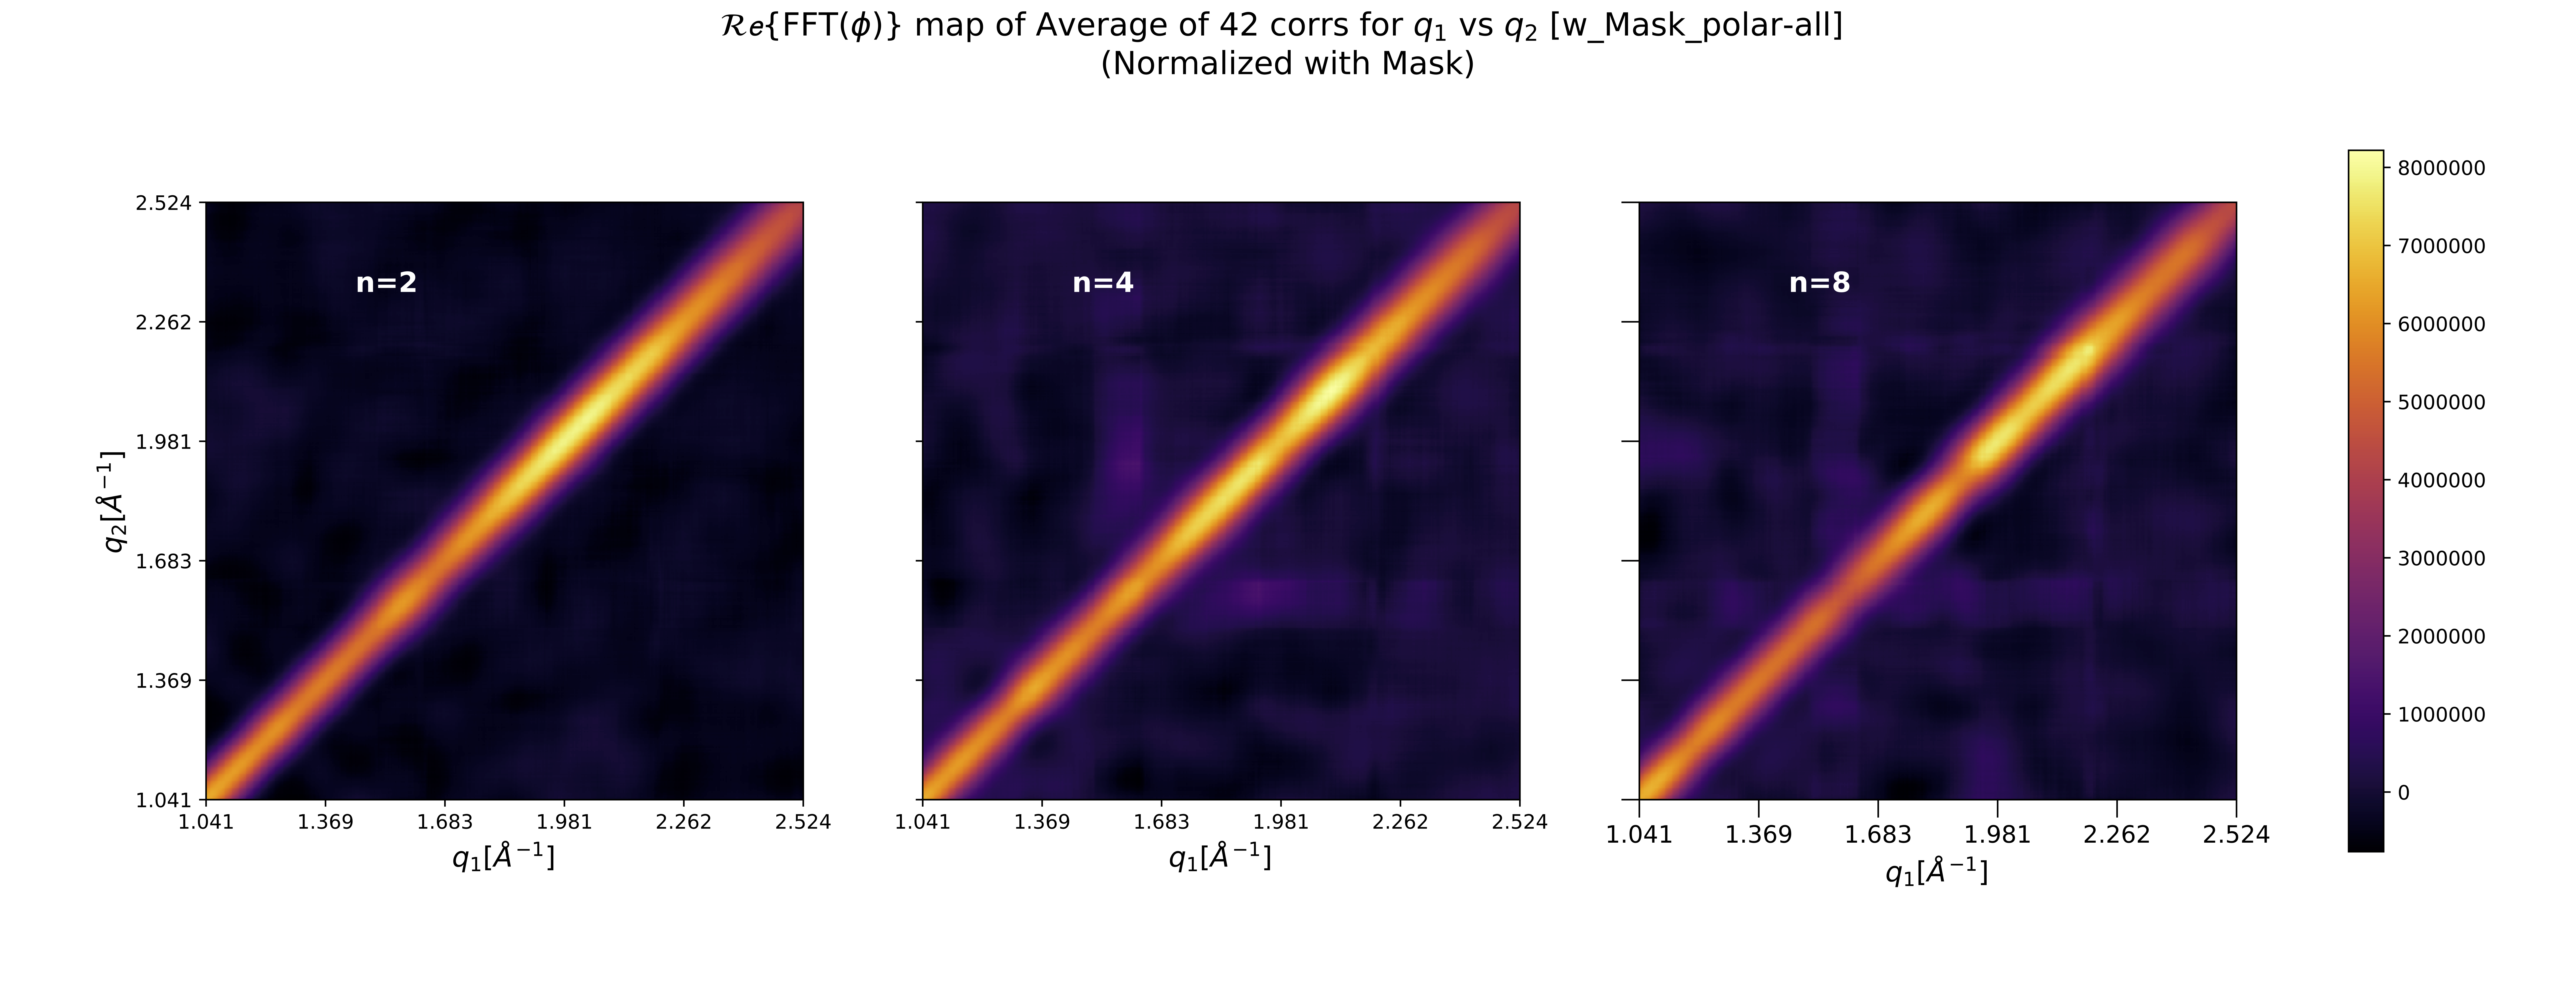